# Ramp 4's characterization of anomaly

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter
import time
#from nptdms import TdmsFile #Process raw ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 0. Helper functions

In [6]:
#Loading data function
def load_channel_and_time(dir_path, channel):
    """Loading a channel from a directory and return a pandas data frame with two columns, channle and time"""
    
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    
    return data_frame


#Plot a single channel, used by next function
def plot_channel(data, channel, time_range = None):
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #plot
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.xlabel("Time (s)")
    plt.ylabel("Volt")
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

#Plotting data function
def load_and_plot(dir_path, channel, time_range = None):
    """Load a particular channel from a quench, and then plot it.  
    """
    ai = load_channel_and_time(dir_path, channel)
    
    plot_channel(ai, channel, time_range = time_range)
    
    #Just for dumping data from RAM on the server, needed when processing larger amount of data
    #don't need to worry about this for now. 
    %reset -f in
    
#Spectrogram plotting function
def plot_spectrogram(dir_path, channel, time_range, window = 1500, step = 10, window_type = 'hanning'):
    
    #Select appropriate time segment
    data = load_channel_and_time(dir_path, channel)

    start = time_range[0]
    end = time_range[1]

    data = data[(data["time"] > start) & (data["time"] < end)]


    from scipy import signal
    
    #FFT
    freqs, times, Sx = signal.spectrogram(data[channel].to_numpy(), fs=100000, window= window_type,
                                      nperseg=window, noverlap= window - step,
                                      detrend=False, scaling='spectrum')
    
    #Dump data from RAM
    %reset -f in
    
    #Plot!
    f, ax = plt.subplots(figsize=(20,2))
    ax.pcolormesh(data["time"].iloc[window-1::step], freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_title("Spectrogram of sensor {}".format(channel))
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');
    
#Counting zero crossing points
def zero_crossings(array):
    
    #zero_crossings = np.where(np.diff(np.sign(array)))[0].shape[0]
    
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()
    
    return zero_crossings

def calculate_zero_crossings(dir_path, channel, time_range = None):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    %reset -f in
    
    return zero_crossings(data[channel].to_numpy())

def plot_zero_crossings(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(zero_crossings, raw = True),
             label = "Number of zero-crossings",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Zero crossings".format(channel))
    plt.show()
    
    %reset -f in

#RMS value analysis
def rms(data):
    return np.nanmean(np.sqrt(data**2))

def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata

def plot_rms(dir_path, channel, time_range = None, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    rms_sensor = load_sensor(dir_path, channel, time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, 
             rms_sensor,
             label = "Moving RMS",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving RMS".format(channel))
    plt.show()
    
def plot_rms_product(dir_path, time_range = None, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of R.M.S.")
    
## Moving max of signal amplitude
def plot_max(dir_path, channel, time_range = None, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    max_sensor = load_sensor(dir_path, channel, time_range = time_range).abs().rolling(window=window).max().to_numpy()[window-1::step]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, 
             max_sensor,
             label = "Moving max of signal amplitude",
             color = 'firebrick')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving max amplitude".format(channel))
    plt.show()

    
#Wavelet analysis
import pywt

def filter_bank(dir_path, sensor, time_range):

    #Load time and data
    chirp_signal = load_sensor(dir_path, sensor, time_range)
    x = np.linspace(0, 1, num=len(chirp_signal))

    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal")
    ax.plot(chirp_signal)
    plt.show()

    data = chirp_signal
    waveletname = 'sym5'

    #Initialize plot grid
    fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))

    #Wavelet transform for different levels
    for ii in range(5):

        #Obtain approximation coefficients and detail coefficients
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')


        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])

        #Set label for first set of plot
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)

        axarr[ii, 1].set_yticklabels([])

    #Additional formatting
    plt.tight_layout()
    plt.show()

## 1. Main characterization

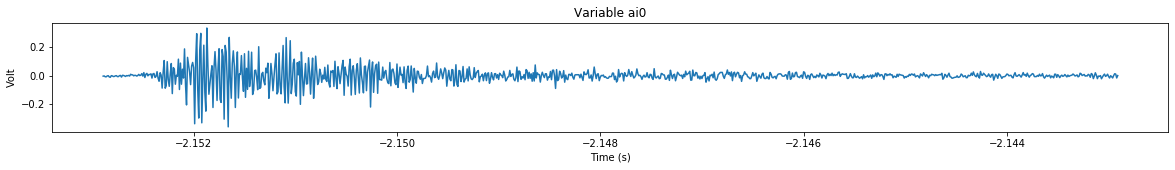

Flushing input history
Flushing input history


In [6]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-2.1529, -2.1529 + 10e-3))

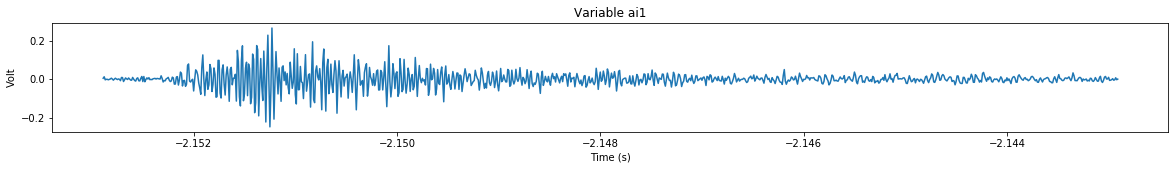

Flushing input history
Flushing input history


In [7]:
load_and_plot("./data/Ramp4/", "ai1", time_range = (-2.1529, -2.1529 + 10e-3))

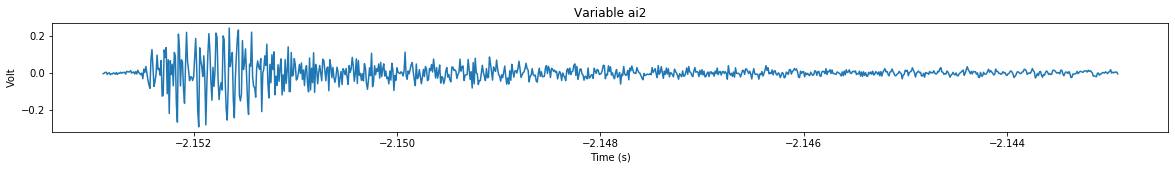

Flushing input history
Flushing input history


In [19]:
load_and_plot("./data/Ramp4/", "ai2", time_range = (-2.1529, -2.1529 + 10e-3))

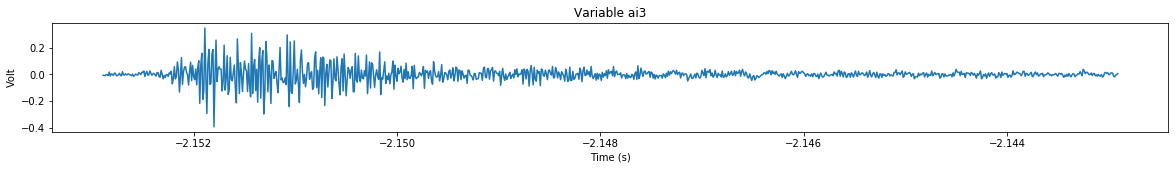

Flushing input history
Flushing input history


In [9]:
load_and_plot("./data/Ramp4/", "ai3", time_range = (-2.1529, -2.1529 + 10e-3))

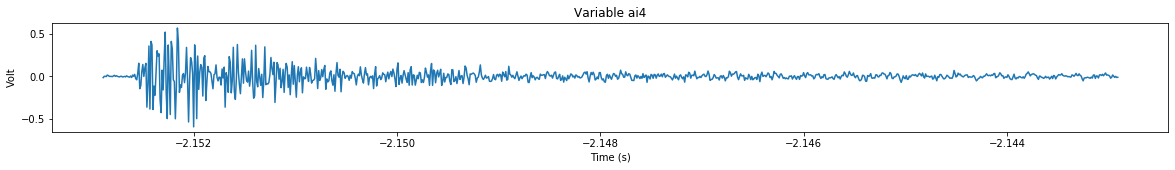

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp4/", "ai4", time_range = (-2.1529, -2.1529 + 10e-3))

#### Zoomed in on the main event

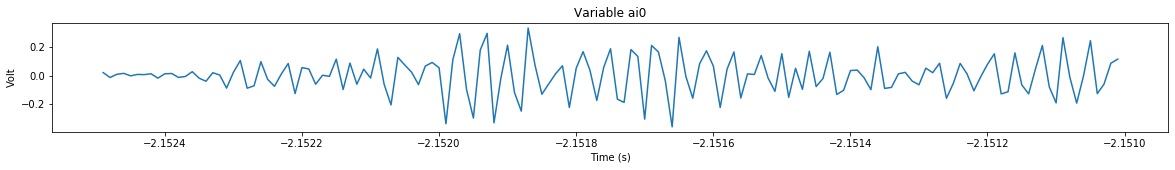

Flushing input history
Flushing input history


In [20]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-2.1525, -2.1525 + 1.5e-3))

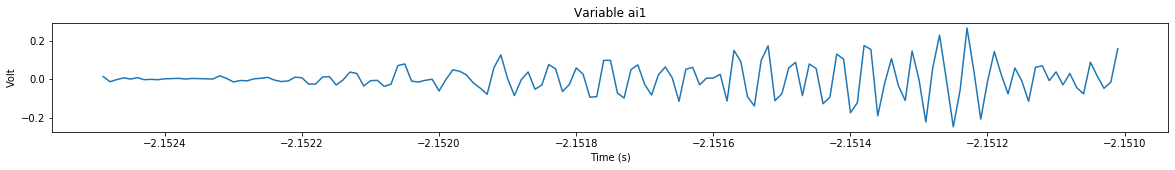

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp4/", "ai1", time_range = (-2.1525, -2.1525 + 1.5e-3))

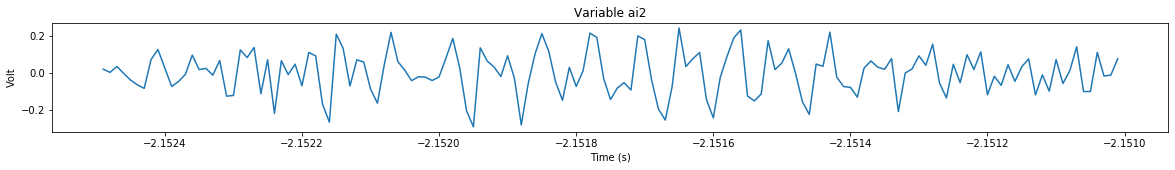

Flushing input history
Flushing input history


In [22]:
load_and_plot("./data/Ramp4/", "ai2", time_range = (-2.1525, -2.1525 + 1.5e-3))

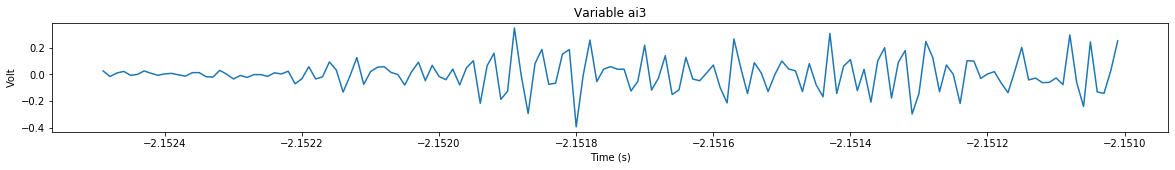

Flushing input history
Flushing input history


In [23]:
load_and_plot("./data/Ramp4/", "ai3", time_range = (-2.1525, -2.1525 + 1.5e-3))

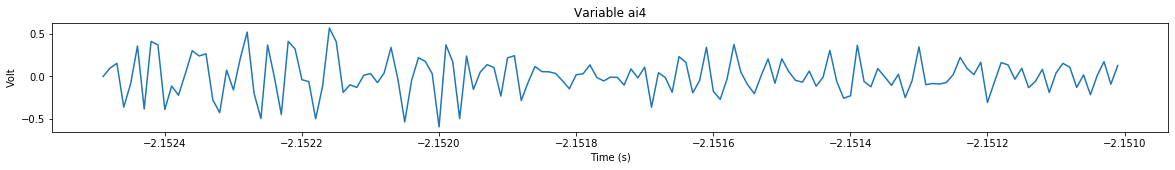

Flushing input history
Flushing input history


In [24]:
load_and_plot("./data/Ramp4/", "ai4", time_range = (-2.1525, -2.1525 + 1.5e-3))

#### Count the number of zero crossings

In [25]:
calculate_zero_crossings("./data/Ramp4/", "ai2", time_range = (-2.1525, -2.1525 + 1.5e-3))

Flushing input history


64

In [26]:
calculate_zero_crossings("./data/Ramp4/", "ai4", time_range = (-2.1525, -2.1525 + 1.5e-3))

Flushing input history


78

In [29]:
calculate_zero_crossings("./data/Ramp4/", "ai0", time_range = (-2.1525 + 0.3e-3, -2.1525 + 1.8e-3))

Flushing input history


88

In [30]:
calculate_zero_crossings("./data/Ramp4/", "ai1", time_range = (-2.1525 + 0.3e-3, -2.1525 + 1.8e-3))

Flushing input history


76

In [31]:
calculate_zero_crossings("./data/Ramp4/", "ai3", time_range = (-2.1525 + 0.3e-3, -2.1525 + 1.8e-3))

Flushing input history


85

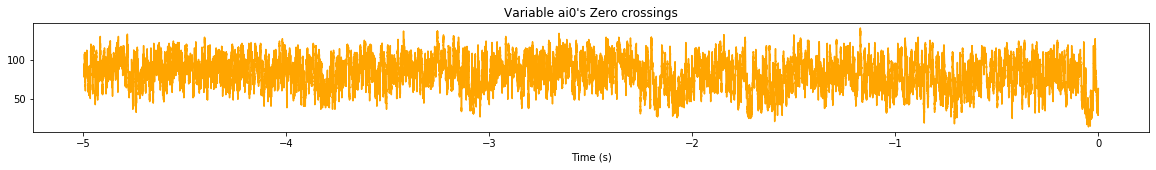

Flushing input history


In [5]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-5, 0), window = 200)

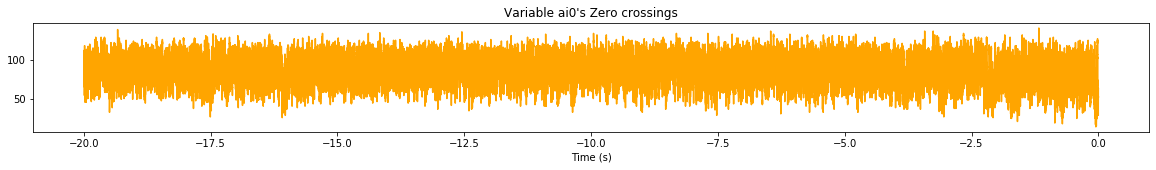

Flushing input history


In [4]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 200)

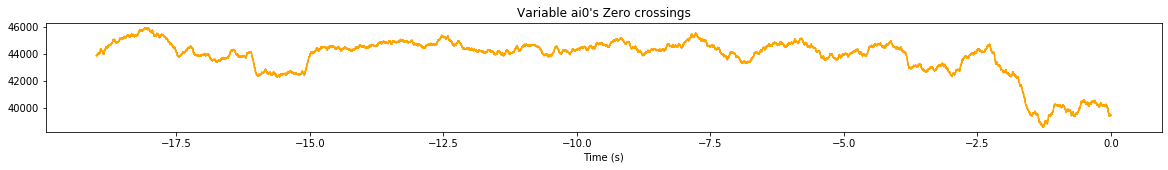

Flushing input history


In [8]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 100000)

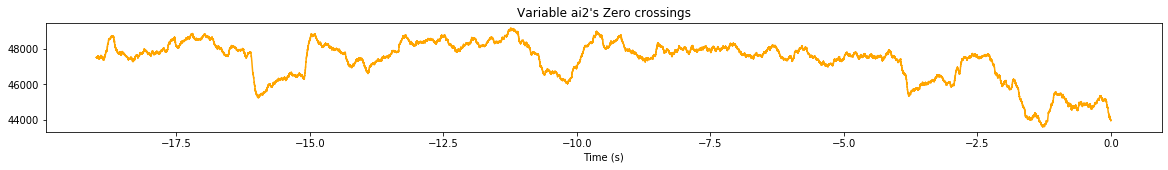

Flushing input history


In [9]:
plot_zero_crossings("./data/Ramp4/", "ai2", time_range = (-20, 0), window = 100000)

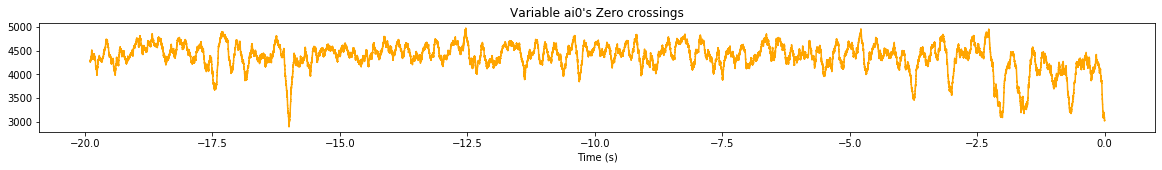

Flushing input history


In [14]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 10000)

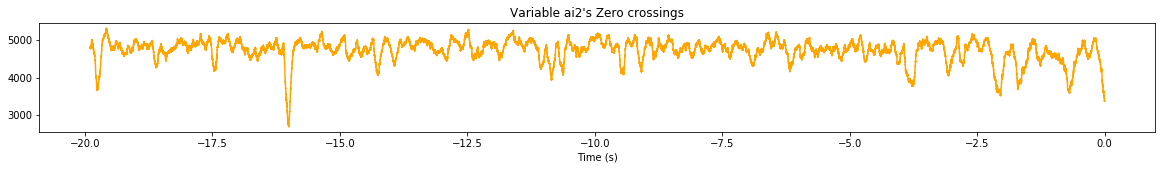

Flushing input history


In [4]:
plot_zero_crossings("./data/Ramp4/", "ai2", time_range = (-20, 0), window = 10000)

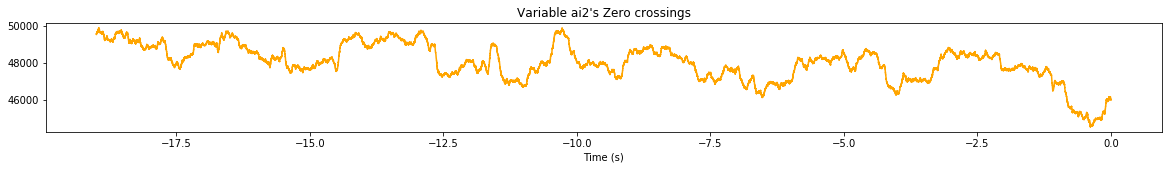

Flushing input history


In [10]:
plot_zero_crossings("./data/Ramp22/", "ai2", time_range = (-20, 0), window = 100000)

#### Zero-crossings different window size

#### 20ms

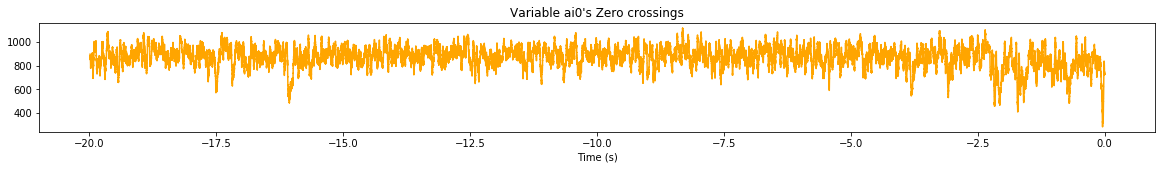

Flushing input history


In [11]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 2000)

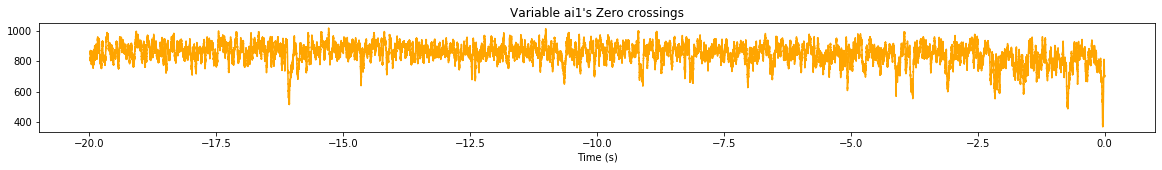

Flushing input history


In [12]:
plot_zero_crossings("./data/Ramp4/", "ai1", time_range = (-20, 0), window = 2000)

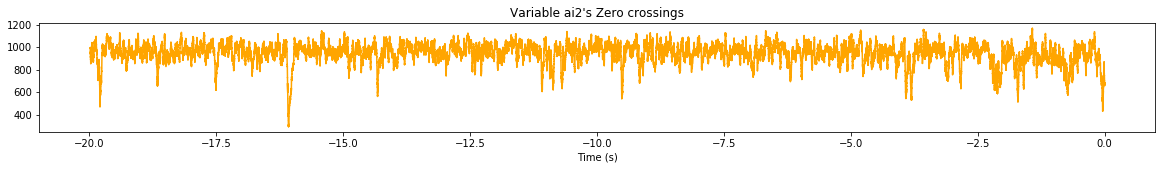

Flushing input history


In [13]:
plot_zero_crossings("./data/Ramp4/", "ai2", time_range = (-20, 0), window = 2000)

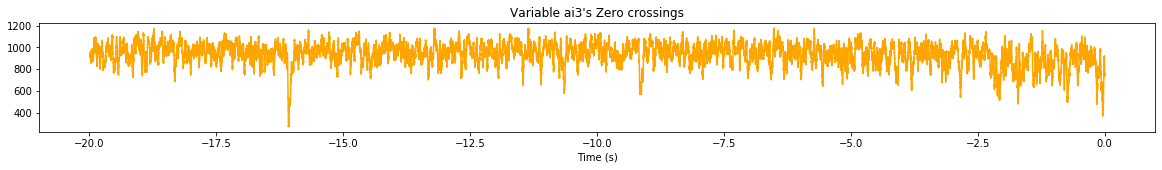

Flushing input history


In [14]:
plot_zero_crossings("./data/Ramp4/", "ai3", time_range = (-20, 0), window = 2000)

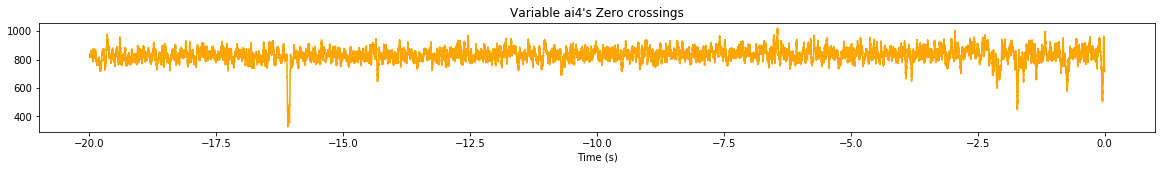

Flushing input history


In [15]:
plot_zero_crossings("./data/Ramp4/", "ai4", time_range = (-20, 0), window = 2000)

#### 100ms

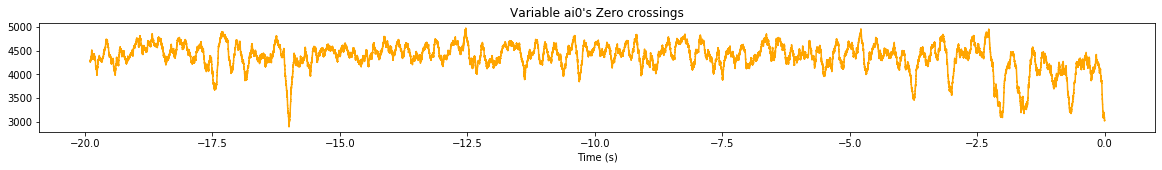

Flushing input history


In [16]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 10000)

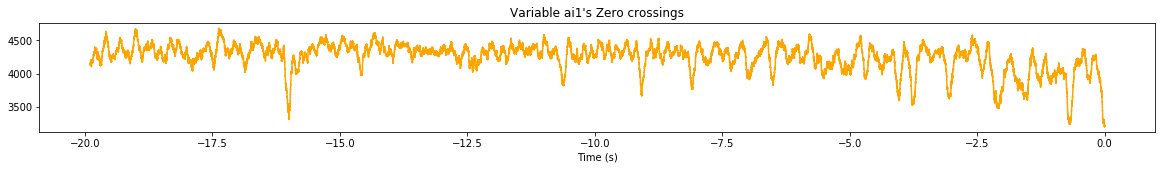

Flushing input history


In [17]:
plot_zero_crossings("./data/Ramp4/", "ai1", time_range = (-20, 0), window = 10000)

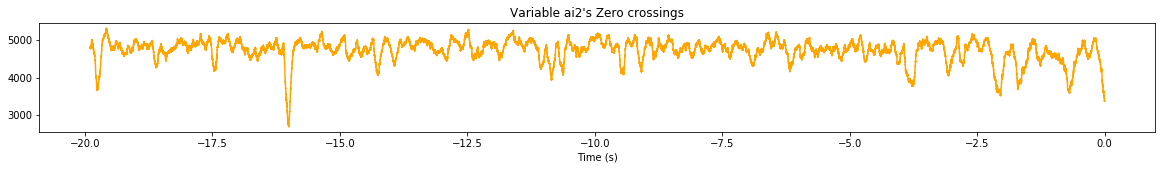

Flushing input history


In [18]:
plot_zero_crossings("./data/Ramp4/", "ai2", time_range = (-20, 0), window = 10000)

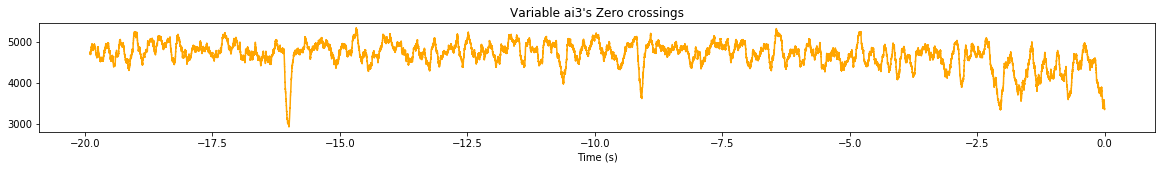

Flushing input history


In [19]:
plot_zero_crossings("./data/Ramp4/", "ai3", time_range = (-20, 0), window = 10000)

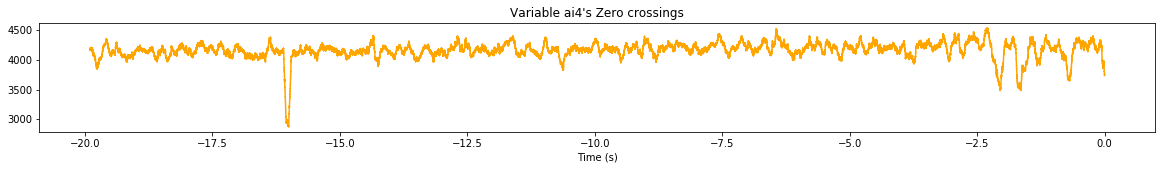

Flushing input history


In [20]:
plot_zero_crossings("./data/Ramp4/", "ai4", time_range = (-20, 0), window = 10000)

#### 1s

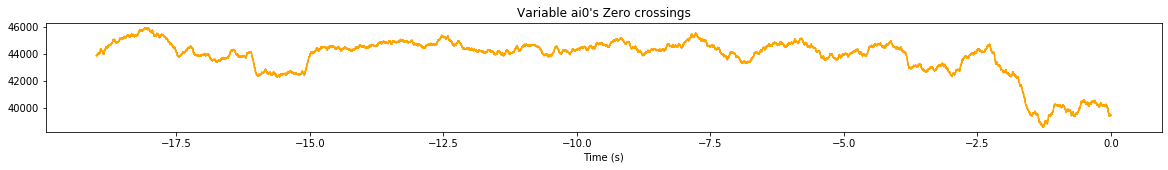

Flushing input history


In [21]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, 0), window = 100000)

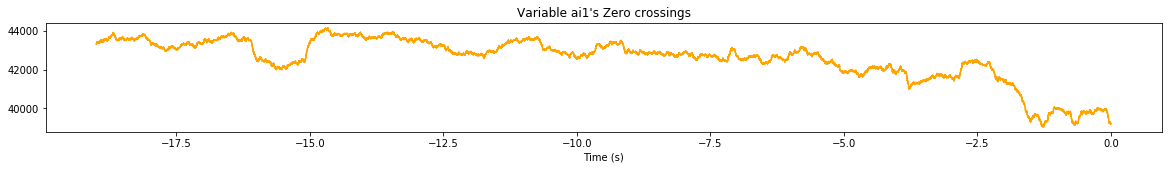

Flushing input history


In [22]:
plot_zero_crossings("./data/Ramp4/", "ai1", time_range = (-20, 0), window = 100000)

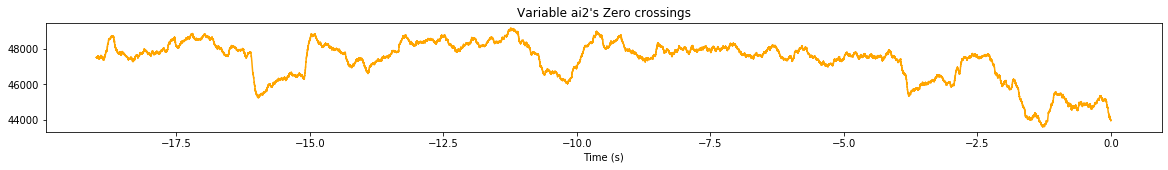

Flushing input history


In [23]:
plot_zero_crossings("./data/Ramp4/", "ai2", time_range = (-20, 0), window = 100000)

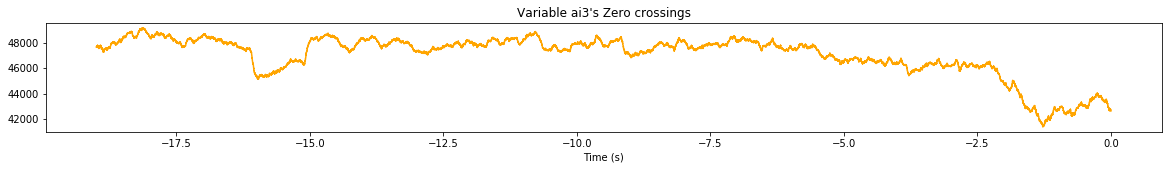

Flushing input history


In [24]:
plot_zero_crossings("./data/Ramp4/", "ai3", time_range = (-20, 0), window = 100000)

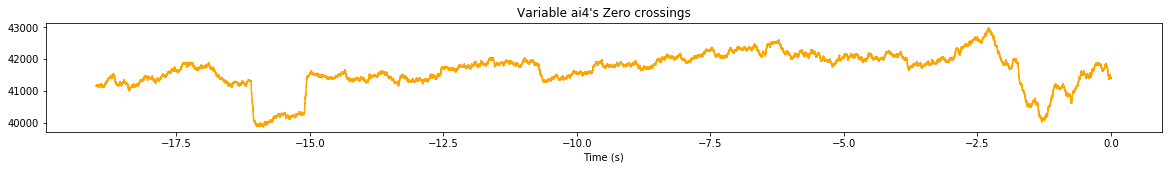

Flushing input history


In [25]:
plot_zero_crossings("./data/Ramp4/", "ai4", time_range = (-20, 0), window = 100000)

#### Ramp22

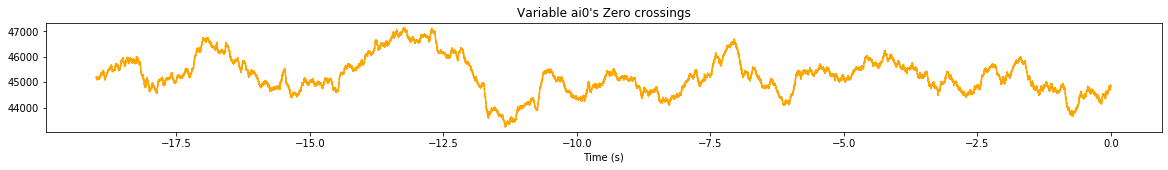

Flushing input history


In [26]:
plot_zero_crossings("./data/Ramp22/", "ai0", time_range = (-20, 0), window = 100000)

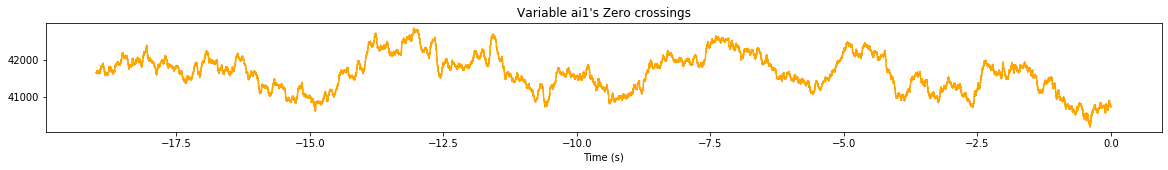

Flushing input history


In [27]:
plot_zero_crossings("./data/Ramp22/", "ai1", time_range = (-20, 0), window = 100000)

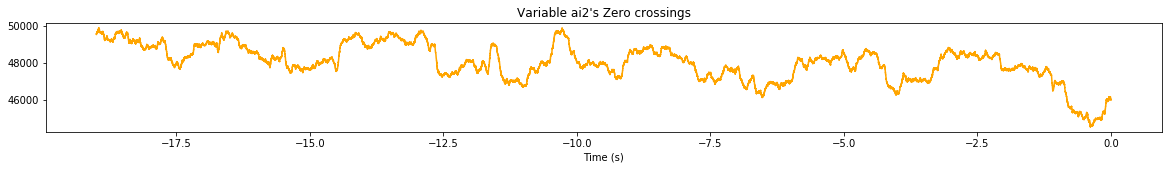

Flushing input history


In [28]:
plot_zero_crossings("./data/Ramp22/", "ai2", time_range = (-20, 0), window = 100000)

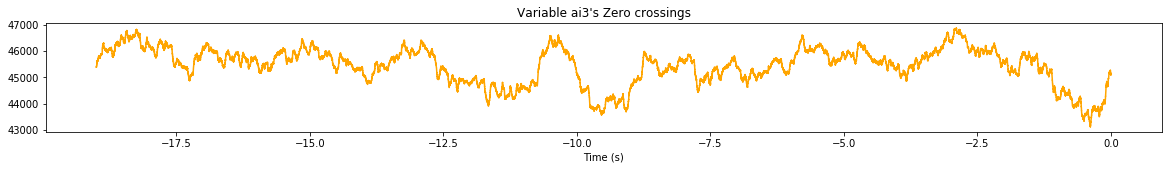

Flushing input history


In [29]:
plot_zero_crossings("./data/Ramp22/", "ai3", time_range = (-20, 0), window = 100000)

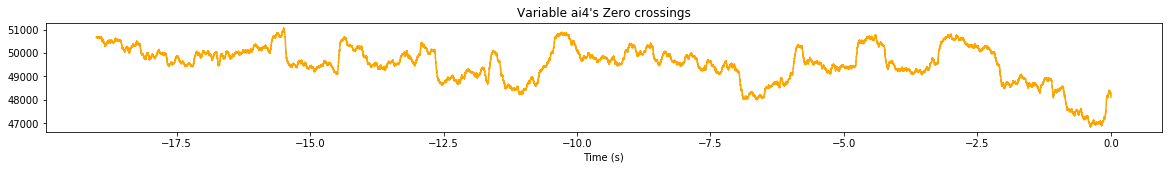

Flushing input history


In [30]:
plot_zero_crossings("./data/Ramp22/", "ai4", time_range = (-20, 0), window = 100000)

####  RMS value of the signal

Flushing input history
Flushing input history


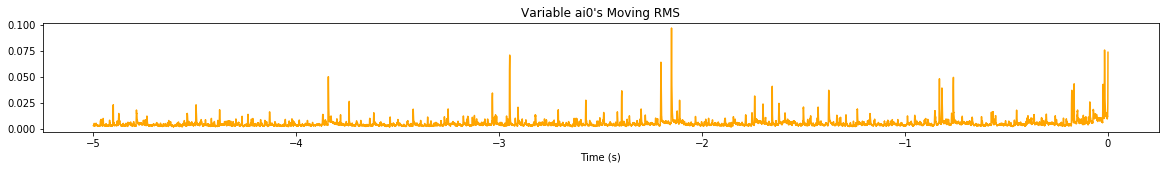

In [38]:
plot_rms("./data/Ramp4/", "ai0", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


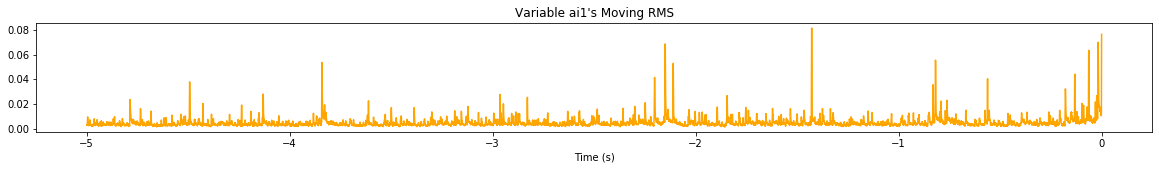

In [39]:
plot_rms("./data/Ramp4/", "ai1", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


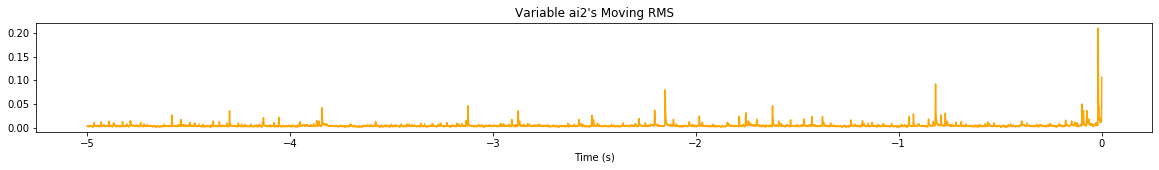

In [40]:
plot_rms("./data/Ramp4/", "ai2", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


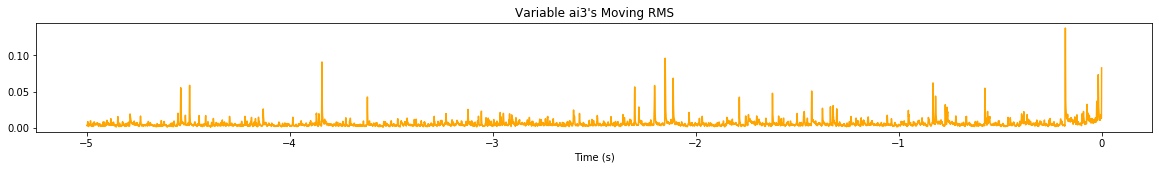

In [41]:
plot_rms("./data/Ramp4/", "ai3", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


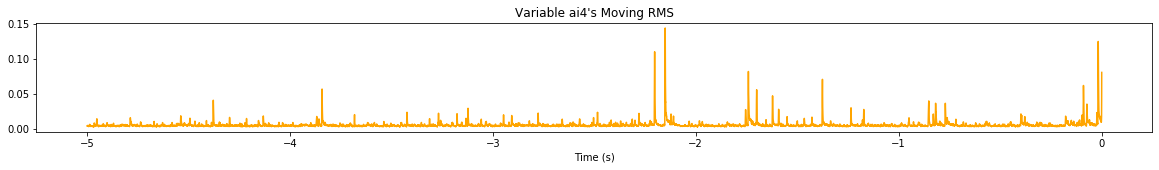

In [42]:
plot_rms("./data/Ramp4/", "ai4", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


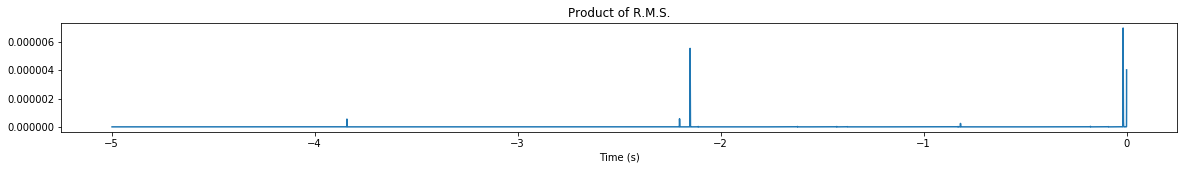

In [46]:
#Product of all the rms values
plot_rms_product("./data/Ramp4/", time_range = (-5, 0), window = 200, step = 10)

#### Moving max of signal amplitude

Flushing input history
Flushing input history


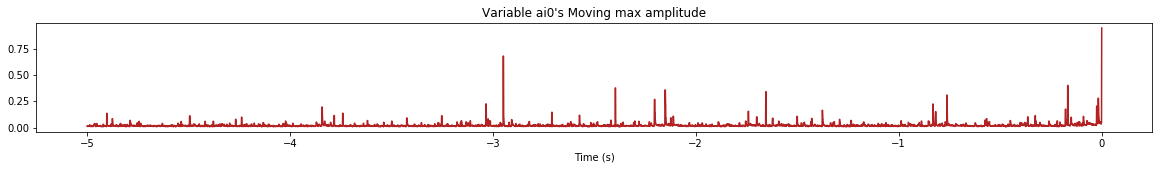

In [7]:
plot_max("./data/Ramp4/", "ai0", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


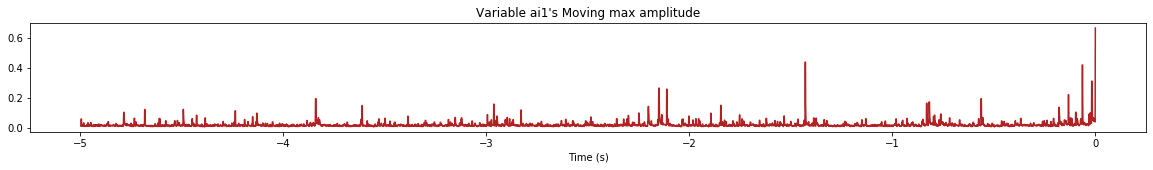

In [9]:
plot_max("./data/Ramp4/", "ai1", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


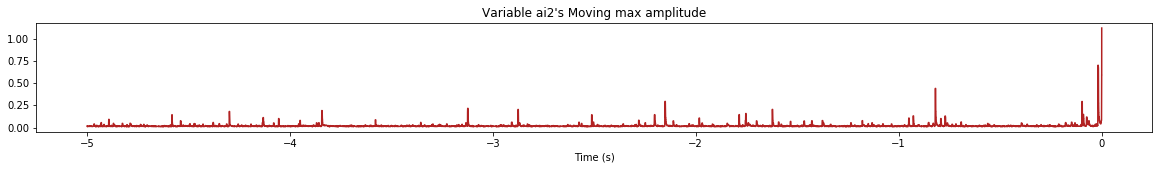

In [10]:
plot_max("./data/Ramp4/", "ai2", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


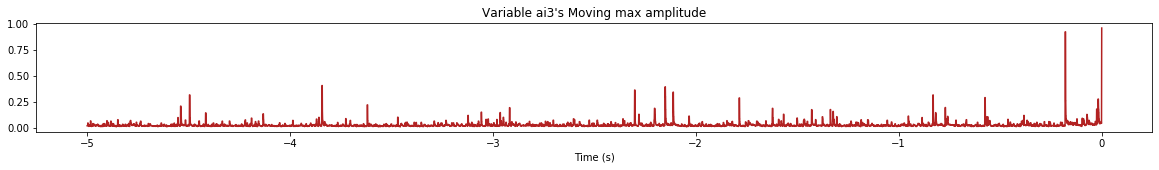

In [11]:
plot_max("./data/Ramp4/", "ai3", time_range = (-5, 0), window = 200, step = 10)

Flushing input history
Flushing input history


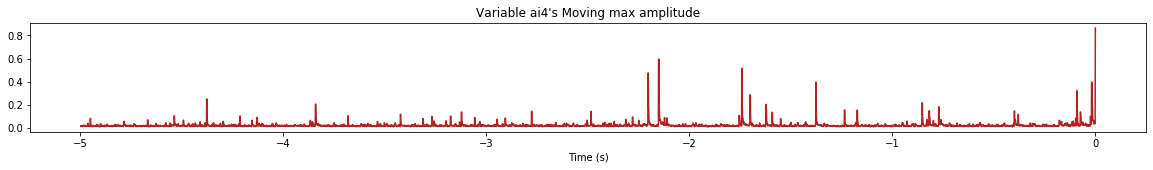

In [12]:
plot_max("./data/Ramp4/", "ai4", time_range = (-5, 0), window = 200, step = 10)

## 2. Spectral analysis

#### 2.1 Spectrogram

Flushing input history


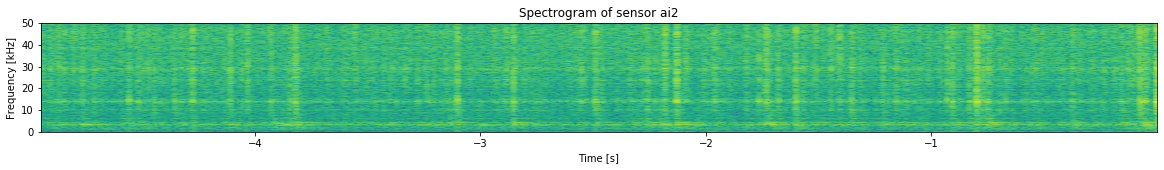

In [3]:
plot_spectrogram("./data/Ramp4/", "ai2", time_range = (-5, 0), window = 5000, step = 10, window_type = 'hanning')

Flushing input history


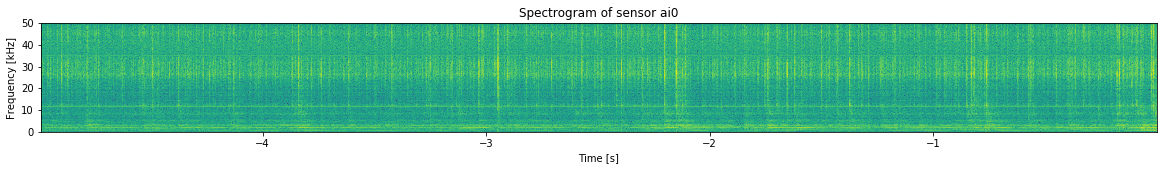

In [6]:
plot_spectrogram("./data/Ramp4/", "ai0", time_range = (-5, 0), window = 800, step = 10, window_type = 'hanning')

Flushing input history


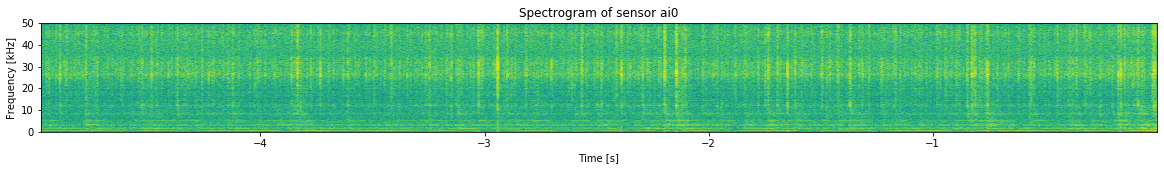

In [3]:
plot_spectrogram("./data/Ramp4/", "ai0", time_range = (-5, 0), window = 2000, step = 10, window_type = 'hanning')

#### 2.2 Filter bank

Flushing input history


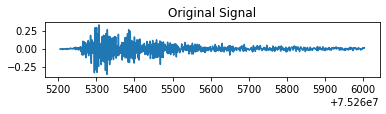

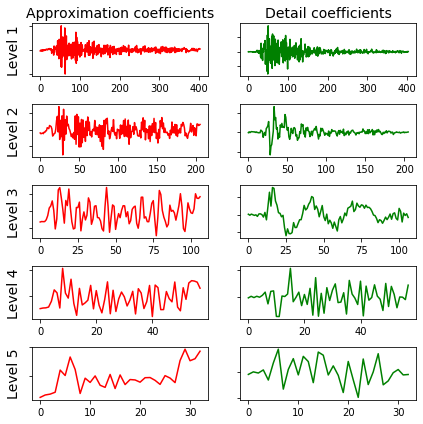

In [13]:
filter_bank("./data/Ramp4/", "ai0", time_range = (-2.1529, -2.1529 + 8e-3))

Flushing input history


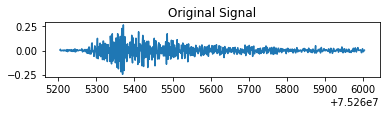

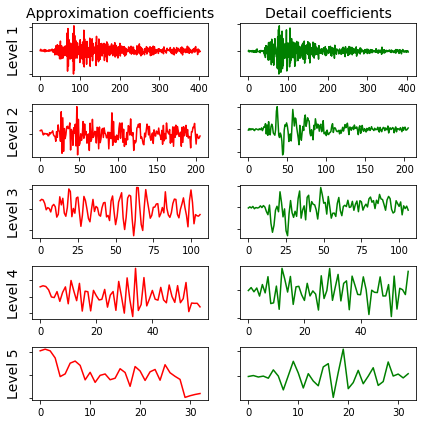

In [14]:
filter_bank("./data/Ramp4/", "ai1", time_range = (-2.1529, -2.1529 + 8e-3))

Flushing input history


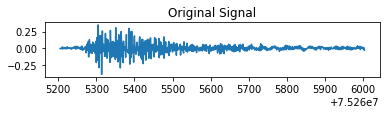

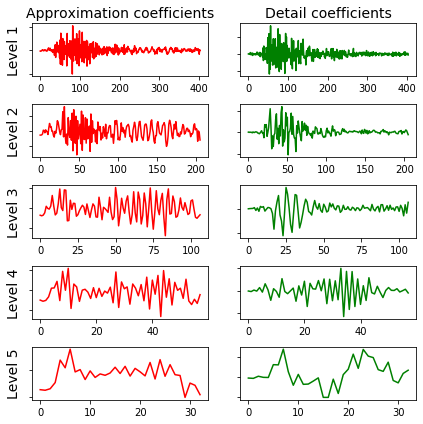

In [15]:
filter_bank("./data/Ramp4/", "ai3", time_range = (-2.1529, -2.1529 + 8e-3))

Flushing input history


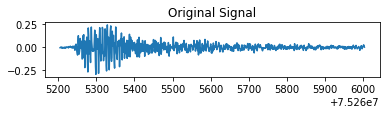

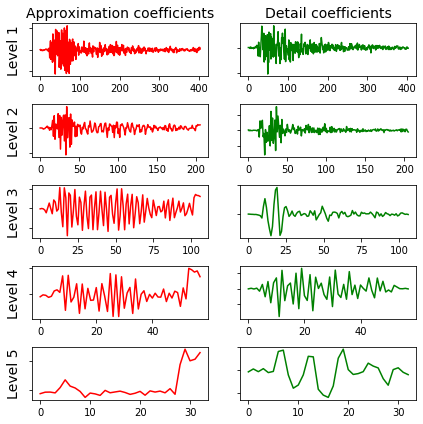

In [16]:
filter_bank("./data/Ramp4/", "ai2", time_range = (-2.1529, -2.1529 + 8e-3))

Flushing input history


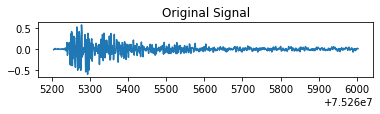

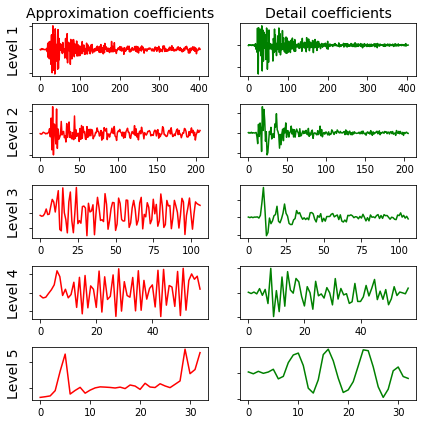

In [17]:
filter_bank("./data/Ramp4/", "ai4", time_range = (-2.1529, -2.1529 + 8e-3))